<a href="https://colab.research.google.com/github/ZeynepRuveyda/automated_classification/blob/main/LClassification_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import

In [ ]:
%%capture
!pip install awscli

In [ ]:
import awscli

In [ ]:
# Import general Custom Libraries
import tensorflow as tf
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import argparse


#Manuel dataset imports
from pathlib import Path
from zipfile import ZipFile
import shutil
from sklearn.model_selection import train_test_split
import time
import random
import seaborn as sns
import math
import matplotlib.pyplot as plt
import tqdm
import inspect

#Data Generator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from sklearn.model_selection import train_test_split

#Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Environment variables (needs to connect with AWS/ S3)
##### After getting access S3 and coco format jsons the following Marc-Antoine codes will be used. They were added as comment.  (Load - Extract - Merge Dataset cells ) 

In [ ]:
# AWS


In [ ]:
# Data 
DATASET_DIR = "/content/drive/MyDrive/Automated_Image_Classification/" 

In [ ]:
AWS_DATASET_PATH = ["s3://automi-data-factory/datasets/classif/test1_classif.zip", "s3://automi-data-factory/datasets/classif/test2_classif.zip"]

## Load Dataset

In [ ]:
def connectS3():
    # Connect AWS 
    # Create Credentials string with keys and region
    text_credentials_s3 = f'''
    [default]
    aws_access_key_id = {AWS_ACCESS_KEY_ID}
    aws_secret_access_key = {AWS_SECRET_ACCESS_KEY}
    region = {AWS_REGION}
    '''
    # write the credentials file with above string 
    with open(PATH_CREDENTIALS_S3, 'w') as f:
        f.write(text_credentials_s3)
    # export path of above file as environment variable 
    os.environ['AWS_SHARED_CREDENTIALS_FILE'] = PATH_CREDENTIALS_S3

In [ ]:
def loadDataset(dataset_path):
    # Verify destination directory exist and create it otherwise
    Path(DATASET_DIR).mkdir(exist_ok=True)
    # Verify dataset is not already downloaded 
    dataset_name = Path(dataset_path).name
    if not os.path.exists(Path(DATASET_DIR) / dataset_name):
        try:
            # Download dataset file via command line 
            os.system(f"aws s3 cp {dataset_path} {DATASET_DIR}")
        except:
            print(f'Unable to load dataset : {dataset_name}')
        finally:
            # Verify presence and format of file in the DATASET_DIR folder 
            assert len(list(Path(DATASET_DIR).glob(dataset_name))) == 1

In [ ]:
def load_multiple_datasets(paths : list):
  # loop over all paths 
  for path in paths:
      # call the function which download one dataset
      loadDataset(path)

In [ ]:
def load():
    connectS3()
    load_multiple_datasets(AWS_DATASET_PATH)

In [ ]:
load()

## Extract Dataset

In [ ]:
def unzipDataset(S3_path : Path):
  S3_path = Path(S3_path)
  # define path where the zip had been downloaded 
  local_path = Path(DATASET_DIR) / S3_path.name
  # define destination path where the zip will be unarchived
  dest_path = Path(DATASET_DIR) 
  # create destination path 
  dest_path.mkdir(exist_ok = True)
  # unzip file via cmd line and remove zip file 
  os.system(f"unzip {local_path} -d {dest_path} && rm -f {local_path}")
  # set up the dest dir with the dataset stem (name without extension)
  dest_path = Path(DATASET_DIR)  / S3_path.stem
  # Verify architecture 
  assert (dest_path / 'annotations').exists()
  assert (dest_path / 'annotations' / 'instances_default.json').exists() 
  assert (dest_path / 'images').exists() 
  assert len(list((dest_path / 'images').glob('*.*'))) > 1

In [ ]:
def unzipMultipleDatasets(paths : list):
    for path in paths:
        # for each path passed in argument, call unzipDataset function 
        unzipDataset(path)

In [ ]:
unzipMultipleDatasets(AWS_DATASET_PATH)

## Merge Dataset

In [ ]:
%%capture 
!pip install pyodi

In [ ]:
import json 
from pyodi.apps import coco

In [ ]:
def getAllImagesWithSameNames(path_ds1, path_ds2):
    # get list of img paths in each dataset
    img_list_1 = (path_ds1 / 'images').glob('*.*')
    img_list_2 = (path_ds2 / 'images').glob('*.*')

    # select only img name 
    img_list_1 = [img.name for img in img_list_1]
    img_list_2 = [img.name for img in img_list_2]

    # return the intersection between both set of names 
    return list(set(img_list_1) & set(img_list_2))

In [ ]:
def renameImages(json_path, same_images):
    with open(json_path, "r") as js_fiile:
    # get dictionnary of json file in input 
        data = json.load(js_fiile)
        # extract list of images 
        json_list_images = data['images']
        # find images dir 
        images_dir = Path(json_path).parents[1] / 'images'
        # loop over images with same names 
        for image_name in same_images:
        # loop over list of images in json file  
            for i, json_image in enumerate(json_list_images):
                # find the one corresponding 
                if image_name == json_image['file_name']:
                    print(image_name)
                    image_path = images_dir / image_name
                    # change the name by adding "_1" at the end of his name 
                    name, ext = json_image['file_name'].split('.')
                    data['images'][i]['file_name'] = ".".join((name + '_1', ext))
                    # rename it in his directory using "mv" linux command 
                    path, ext = str(image_path).rsplit('.',1)
                    cmd = f"mv {image_path} " + ".".join((path + '_1', ext))
                    os.system(cmd)

    # overwrite json file 		
    with open(json_path, "w") as js_file:
        json.dump(data, js_file)

In [ ]:
def move_after_merged(path_ds1, path_ds2, path_ds_dest):
    # loop over both dataset path 
    for path_ds in [path_ds1, path_ds2]:
        # loop over image of the current dataset 
        for img_path in (path_ds / 'images').glob('*.*'):
            # copy image to the destination direction 
            cmd = f"cp {str(img_path)} {str(path_ds_dest / 'images')}"
            os.system(cmd)

In [ ]:
def test(p1, p2, p_dest):
    # verify all images have been merged 
    assert len(sorted((p1 / 'images').glob('*.*'))) + len(sorted((p2 / 'images').glob('*.*'))) == len(sorted((p_dest / 'images').glob('*.*')))

    json1_path = str(p1 / "annotations" / "instances_default.json")
    json2_path = str(p2/ "annotations" / "instances_default.json")
    json_dest_path = str(p_dest / "annotations" / "instances_default.json")

    # Verify all annotation have been merged 
    with open(json1_path, "r") as js1:
        # get dictionnary of json file in input 
        data = json.load(js1)
        # extract list of annotations  
        num_anns_ds1  = len(data['annotations'])

    with open(json2_path, "r") as js1:
        # get dictionnary of json file in input 
        data = json.load(js1)
        # extract list of annotations  
        num_anns_ds2  = len(data['annotations'])


    with open(json_dest_path, "r") as js1:
        # get dictionnary of json file in input 
        data = json.load(js1)
        # extract list of annotations  
        num_anns_ds_dest  = len(data['annotations'])

    # Verify all annotations have been merged 
    assert num_anns_ds1 + num_anns_ds2 == num_anns_ds_dest

In [ ]:
def merge_datasets(path_ds1, path_ds2, dest):
    # define destination path
    dest_path = Path(DATASET_DIR) / dest
    # create directory and subdirectories for merge 
    dest_path.mkdir(exist_ok = True)
    for subdir in ['images', 'labels', 'annotations']:
        (dest_path / subdir).mkdir(exist_ok = True)

    # define json paths 
    json1_path = str(path_ds1 / "annotations" / "instances_default.json")
    json2_path = str(path_ds2 / "annotations" / "instances_default.json")
    json_dest_path = str(dest_path / "annotations" / "instances_default.json")

    # find all image with same names 
    renameImages(json2_path, getAllImagesWithSameNames(path_ds1, path_ds2))
    # merge 2 json files using pyodi and define his output name 
    coco.coco_merge(json1_path, json2_path, json_dest_path)

    move_after_merged(path_ds1, path_ds2, dest_path)
    test(path_ds1, path_ds2, dest_path)

In [ ]:
DATASET_DIR

'/content/drive/MyDrive/Automated_Image_Classification/'

In [ ]:
DESTINATION = 'dataset'
if len(AWS_DATASET_PATH) == 2:
  paths = [Path(DATASET_DIR) / Path(p).stem for p in AWS_DATASET_PATH]
  merge_datasets(*paths,DESTINATION)

2022-03-08 13:06:36.830 | INFO     | pyodi.apps.coco.coco_merge:coco_merge:51 - Input 1: 4 images, 4 annotations
2022-03-08 13:06:36.831 | INFO     | pyodi.apps.coco.coco_merge:coco_merge:51 - Input 2: 4 images, 4 annotations
2022-03-08 13:06:36.832 | INFO     | pyodi.apps.coco.coco_merge:coco_merge:89 - Result: 8 images, 8 annotations


In [ ]:
AWS_DATASET_PATH

['s3://automi-data-factory/datasets/classif/test1_classif.zip',
 's3://automi-data-factory/datasets/classif/test2_classif.zip']


###### Convert from COCO to dataframe

In [ ]:
'''import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Automated_Image_Classification/Image/testfor_all_1.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")'''

In [ ]:
with open("/content/drive/MyDrive/Automated_Image_Classification/dataset/annotations/instances_default.json") as json_data:
    data = json.load(json_data)

In [ ]:
df_annotations = pd.DataFrame(data['annotations'])

In [ ]:
df_annotations.drop_duplicates(subset='image_id', keep="last",inplace=True)

In [ ]:
labels = []
for column_name,columnData in df_annotations['attributes'].iteritems():
  labels.append(columnData['label'])

In [ ]:
df_images = pd.DataFrame(data['images'])

In [ ]:
df = pd.DataFrame({'id': df_images.file_name.to_list(), 'label': labels})

In [ ]:
df

,id,label
0,DSC_0601.jpg,marking
1,DSC_0602.jpg,marking
2,DSC_0618.jpg,no_marking
3,DSC_0624.jpg,no_marking
4,LISI-22-012-285476.png,marking
5,LISI-22-012-288481.png,no_marking
6,LISI-22-012-293556.png,marking
7,LISI-22-012-293867.png,no_marking


## Split Dataset

In [ ]:
def test_train_split(df_dir):
    df = pd.read_csv(df_dir)
    train_df, test_df = train_test_split(df, test_size=0.1)
    parent = Path(df_dir).parent
    train_df_path = os.path.join(os.path.expanduser('~'), parent, 'TRAIN_DF.csv')
    test_df_path = os.path.join(os.path.expanduser('~'), parent, 'TEST_DF.csv')
    train_df.to_csv(train_df_path, index=False)
    test_df.to_csv(test_df_path, index=False)
    return train_df, test_df

In [ ]:
# Extracting data from zip
train_df,test_df,path_all_images = create_dataset('/content/drive/MyDrive/Automated_Image_Classification/Image/Data.zip')


Found 2 different class folders. If you have more than 2 nm_classes you should split your images as different folders in zip file.


In [ ]:
# train evaluation data splitting
train_df, eval_df = train_test_split(train_df, test_size=0.2)

## Balance Dataset

** add if statement for balance and not balance dataset **

In [ ]:
# balance checking
def balance_check(train_df):
    counts = train_df.label.value_counts()
    count_dict = counts.to_dict()
    list_count = list(count_dict.values())
    if all(x == list_count[0] for x in list_count) == False:
        print("Training data is not balance.")
        time.sleep(3.0)
        return False
    else:
        print("Training data is balance.")
        return True

In [ ]:
balance = balance_check(train_df)

Training data is not balance.


In [ ]:
# class weight for balance

def create_class_weight(labels_dict, n_classes):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    #x = 0
    for idx, key in enumerate(keys):
        y = labels_dict[key]
        score = (total / n_classes) * (1/y)
        class_weight[idx] = score
        #x += 1
    return class_weight

In [ ]:
# find class weigths for balancing
counts = train_df.label.value_counts()
count_dict = counts.to_dict()
nm_classes = len(train_df.label.unique().tolist())
class_weights = create_class_weight(count_dict,nm_classes)

In [ ]:
#random oversampling for balance

def random_over_sampling(train_df, all_image_path):
    train_df.reset_index(drop=True, inplace=True)
    index = train_df.index
    counts = train_df.label.value_counts()
    count_dict = counts.to_dict()
    max_class = max(count_dict.values())
    max_key = max(count_dict, key=count_dict.get)
    count_dict.pop(max_key)
    names = []
    labels = []
    for key, value in count_dict.items():
        dif = max_class - value
        label_ind = list(index[train_df["label"] == key])
        if len(label_ind) < dif:
            inds = random.choices(label_ind, k=dif)
            j = 0
            for i in inds:
                sample = train_df.iloc[i]
                names.append(str(j) + '_copy_' + sample['id'])
                labels.append((sample['label']))
                im = cv2.imread(os.path.join(os.path.expanduser('~'), all_image_path, sample['id']))
                cv2.imwrite(os.path.join(os.path.expanduser('~'), all_image_path, str(j) + '_copy_' + sample['id']), im)
                j = j + 1
        else:
            inds = random.sample(label_ind, dif)

            for i in inds:
                sample = train_df.iloc[i]
                names.append('copy_' + sample['id'])
                labels.append((sample['label']))
                im = cv2.imread(os.path.join(os.path.expanduser('~'), all_image_path, sample['id']), -1)
                cv2.imwrite(os.path.join(os.path.expanduser('~'), all_image_path, 'copy_' + sample['id']), im)

    new_names = list(train_df.id) + names
    new_labels = list(train_df.label) + labels
    new_train_df = pd.DataFrame({'id': new_names, 'label': new_labels})
    parent = Path(all_image_path).parent
    path_csv = os.path.join(os.path.expanduser('~'), parent, 'TRAIN_DF.csv')
    new_train_df.to_csv(path_csv, index=False)

    return new_train_df

In [ ]:
# random over sampling for balancing
if balance == False :
  print("Class distribution : %s ,Balancing process is started." % (count_dict))
  train_df = random_over_sampling(train_df,path_all_images)
  counts = train_df.label.value_counts()
  count_dict = counts.to_dict()
  print("Class distribution : %s ,Data made balance." % (count_dict))


Class distribution : {'No T': 159, 'T': 60} ,Balancing process is started.
Class distribution : {'No T': 159, 'T': 159} ,Data made balance.


## Data Generator

In [ ]:
class CustomDataGenerator:

    def __init__(self, images_folder_dir, test_df, train_df, eval_df, batch_size, target_size):
        self.images_folder_dir = images_folder_dir
        self.test_df = test_df
        self.train_df = train_df
        self.eval_df = eval_df
        self.batch_size = batch_size
        self.target_size = target_size

    def data_generator(self):
        with tf.device('/device:GPU:0'):
            train_datagen = ImageDataGenerator(
                rescale=1. / 255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
            val_datagen = ImageDataGenerator(
                rescale=1. / 255
            )
            print("Test Dataset : ")
            test_generator = val_datagen.flow_from_dataframe(
                dataframe=self.test_df,
                directory=self.images_folder_dir,
                x_col="id",
                y_col="label",
                target_size=self.target_size,
                batch_size=self.batch_size,
                shuffle=False,
                class_mode="categorical"
            )
            print("Validation Dataset : ")
            val_generator = val_datagen.flow_from_dataframe(

                dataframe=self.eval_df,
                directory=self.images_folder_dir,
                x_col="id",
                y_col="label",
                target_size=self.target_size,
                batch_size=self.batch_size,
                shuffle=True,
                seed=42,
                class_mode="categorical"
            )
            print("Training Dataset : ")
            train_generator = train_datagen.flow_from_dataframe(
                dataframe=self.train_df,
                directory=self.images_folder_dir,
                x_col="id",
                y_col="label",
                target_size=self.target_size,
                batch_size=self.batch_size,
                shuffle=True,
                seed=42,
                class_mode="categorical"
            )
            return train_generator, val_generator, test_generator


In [ ]:
# Creating custom data generator child from class
custom_data = CustomDataGenerator(path_all_images,test_df,train_df,eval_df,32,(224,224))

In [ ]:
# Checking balance and creating training,eval,test generators, then creating class weights
train_generator,val_generator,test_generator = custom_data.data_generator()

Test Dataset : 
Found 31 validated image filenames belonging to 2 classes.
Validation Dataset : 
Found 55 validated image filenames belonging to 2 classes.
Training Dataset : 
Found 318 validated image filenames belonging to 2 classes.


<a id='m'></a>
## Modeling and Selection

***Do you want see all benchmarking of all classification architectures?*** 
Call benchmarking function and see the result. Then you can choose your final architecture for fine tunning. If you do not want use benchmarking you can directly create model from Custom_Model class then you can apply fine tuning.

** add if statement for benchmarking **


In [ ]:
class Custom_Model():
    def __init__(self, model_name,im_size,nm_classes):

        # define all layers in init
        self.IMG_SHAPE = im_size + (3,)
        self.model_name = model_name
        self.nm_classes = nm_classes
        self.dense = tf.keras.layers.Dense(self.nm_classes, activation = 'sigmoid')
        self.flat = tf.keras.layers.Flatten(name="flatten")
        self.model_dictionary = {m[0]: m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
        self.base_model = self.model_dictionary[self.model_name](input_shape=self.IMG_SHAPE, include_top=False,
                                                                 weights='imagenet')
        self.base_model.trainable = False
        self.global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
        self.dropout = tf.keras.layers.Dropout(0.2)

    def forward(self):
        input_ = tf.keras.Input(shape=self.IMG_SHAPE)
        x = self.base_model(input_,training=False)
        x = self.global_average_layer(x)
        #x = self.dropout(x)
        outputs = self.dense(x)
        model = tf.keras.Model(input_,outputs)
        
        return model

In [ ]:
def model_selection(train_generator,validation_generator,im_size,nm_classes):
    model_dictionary = {m[0]: m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
    model_dictionary.pop('NASNetLarge')
    model_benchmarks = {'model_name': [], 'num_model_params': [] ,'validation_accuracy': []}
    for model_name, model in tqdm(model_dictionary.items()):

        model_ = Custom_Model(model_name,im_size,nm_classes)
        # custom modifications on top of pre-trained model
        model_ = model_.forward()
        base_learning_rate = 0.0001
        model_.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        history = model_.fit(train_generator, epochs=3, validation_data=validation_generator,)

        model_benchmarks['model_name'].append(model_name)
        model_benchmarks['num_model_params'].append(model_.count_params())
        model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])
        benchmark_df = pd.DataFrame(model_benchmarks)
        benchmark_df.to_csv('benchmark_df.csv', index=False)  # write results to csv file

    return benchmark_df

In [ ]:
#Training all models
benchmark_df = model_selection(train_generator,val_generator,(224,224),nm_classes)

  0%|          | 0/34 [00:00<?, ?it/s]

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 23s 827ms/step - loss: 0.7671 - accuracy: 0.4403 - val_loss: 0.7561 - val_accuracy: 0.4545
Epoch 2/3
10/10 [==============================] - 6s 567ms/step - loss: 0.7274 - accuracy: 0.4874 - val_loss: 0.7267 - val_accuracy: 0.5091
Epoch 3/3
10/10 [==============================] - 6s 569ms/step - loss: 0.6924 - accuracy: 0.5975 - val_loss: 0.6959 - val_accuracy: 0.5455


  3%|▎         | 1/34 [00:39<21:48, 39.64s/it]

51888128/51877672 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 16s 840ms/step - loss: 0.6031 - accuracy: 0.8270 - val_loss: 0.5626 - val_accuracy: 0.8000
Epoch 2/3
10/10 [==============================] - 6s 566ms/step - loss: 0.5586 - accuracy: 0.8836 - val_loss: 0.5012 - val_accuracy: 0.8182
Epoch 3/3
10/10 [==============================] - 6s 563ms/step - loss: 0.5321 - accuracy: 0.9057 - val_loss: 0.4604 - val_accuracy: 0.8909


  6%|▌         | 2/34 [01:12<19:04, 35.76s/it]

74850304/74836368 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 18s 904ms/step - loss: 0.7900 - accuracy: 0.3711 - val_loss: 0.8027 - val_accuracy: 0.3273
Epoch 2/3
10/10 [==============================] - 6s 567ms/step - loss: 0.7484 - accuracy: 0.4214 - val_loss: 0.7635 - val_accuracy: 0.3455
Epoch 3/3
10/10 [==============================] - 6s 580ms/step - loss: 0.6965 - accuracy: 0.5440 - val_loss: 0.7394 - val_accuracy: 0.3818


  9%|▉         | 3/34 [01:49<18:36, 36.03s/it]

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 12s 696ms/step - loss: 0.6936 - accuracy: 0.4748 - val_loss: 0.6960 - val_accuracy: 0.1818
Epoch 2/3
10/10 [==============================] - 6s 567ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6974 - val_accuracy: 0.1818
Epoch 3/3
10/10 [==============================] - 6s 572ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.1818


 12%|█▏        | 4/34 [02:15<16:09, 32.30s/it]

27033600/27018416 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 15s 821ms/step - loss: 0.6952 - accuracy: 0.5000 - val_loss: 0.6758 - val_accuracy: 0.8182
Epoch 2/3
10/10 [==============================] - 6s 561ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6851 - val_accuracy: 0.8182
Epoch 3/3
10/10 [==============================] - 6s 568ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6857 - val_accuracy: 0.8182


 15%|█▍        | 5/34 [02:47<15:30, 32.09s/it]

31801344/31790344 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 15s 775ms/step - loss: 0.6961 - accuracy: 0.5000 - val_loss: 0.7282 - val_accuracy: 0.1818
Epoch 2/3
10/10 [==============================] - 6s 565ms/step - loss: 0.6945 - accuracy: 0.5000 - val_loss: 0.7182 - val_accuracy: 0.1818
Epoch 3/3
10/10 [==============================] - 6s 559ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.7061 - val_accuracy: 0.1818


 18%|█▊        | 6/34 [03:17<14:43, 31.54s/it]

43950080/43941136 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 17s 822ms/step - loss: 0.6974 - accuracy: 0.5000 - val_loss: 0.6745 - val_accuracy: 0.8182
Epoch 2/3
10/10 [==============================] - 6s 569ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6877 - val_accuracy: 0.8182
Epoch 3/3
10/10 [==============================] - 6s 570ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6855 - val_accuracy: 0.8182


 21%|██        | 7/34 [03:51<14:29, 32.20s/it]

71696384/71686520 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 19s 880ms/step - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.6678 - val_accuracy: 0.8182
Epoch 2/3
10/10 [==============================] - 6s 563ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6846 - val_accuracy: 0.8182
Epoch 3/3
10/10 [==============================] - 6s 571ms/step - loss: 0.6933 - accuracy: 0.4937 - val_loss: 0.7042 - val_accuracy: 0.1818


 24%|██▎       | 8/34 [04:28<14:37, 33.74s/it]

115277824/115263384 [==============================] - 2s 0us/step
Epoch 1/3
10/10 [==============================] - 22s 921ms/step - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.6632 - val_accuracy: 0.8182
Epoch 2/3
10/10 [==============================] - 6s 570ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6792 - val_accuracy: 0.8182
Epoch 3/3
10/10 [==============================] - 6s 573ms/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6948 - val_accuracy: 0.1818


 26%|██▋       | 9/34 [05:10<15:05, 36.22s/it]

165249024/165234480 [==============================] - 3s 0us/step
Epoch 1/3
10/10 [==============================] - 23s 1s/step - loss: 0.6973 - accuracy: 0.5000 - val_loss: 0.6686 - val_accuracy: 0.8182
Epoch 2/3
10/10 [==============================] - 6s 580ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6894 - val_accuracy: 0.8182
Epoch 3/3
10/10 [==============================] - 6s 572ms/step - loss: 0.6935 - accuracy: 0.4748 - val_loss: 0.7041 - val_accuracy: 0.1818


 29%|██▉       | 10/34 [05:56<15:44, 39.34s/it]

258088960/258076736 [==============================] - 2s 0us/step
Epoch 1/3
10/10 [==============================] - 29s 1s/step - loss: 0.7017 - accuracy: 0.5000 - val_loss: 0.6574 - val_accuracy: 0.8182
Epoch 2/3
10/10 [==============================] - 6s 579ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6883 - val_accuracy: 0.8182
Epoch 3/3
10/10 [==============================] - 6s 581ms/step - loss: 0.6942 - accuracy: 0.4811 - val_loss: 0.7098 - val_accuracy: 0.1818


 32%|███▏      | 11/34 [06:47<16:26, 42.88s/it]

24289280/24274472 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 12s 727ms/step - loss: 0.6954 - accuracy: 0.4686 - val_loss: 0.6759 - val_accuracy: 0.8182
Epoch 2/3
10/10 [==============================] - 6s 556ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6839 - val_accuracy: 0.8182
Epoch 3/3
10/10 [==============================] - 6s 556ms/step - loss: 0.6941 - accuracy: 0.4434 - val_loss: 0.6986 - val_accuracy: 0.1818


 35%|███▌      | 12/34 [07:14<13:59, 38.16s/it]

28467200/28456008 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 14s 774ms/step - loss: 0.6980 - accuracy: 0.5000 - val_loss: 0.6558 - val_accuracy: 0.8182
Epoch 2/3
10/10 [==============================] - 6s 556ms/step - loss: 0.6951 - accuracy: 0.5000 - val_loss: 0.6808 - val_accuracy: 0.8182
Epoch 3/3
10/10 [==============================] - 6s 566ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6917 - val_accuracy: 0.8182


 38%|███▊      | 13/34 [07:46<12:42, 36.29s/it]

35848192/35839040 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 15s 786ms/step - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.7161 - val_accuracy: 0.1818
Epoch 2/3
10/10 [==============================] - 6s 558ms/step - loss: 0.6949 - accuracy: 0.4340 - val_loss: 0.6900 - val_accuracy: 0.8182
Epoch 3/3
10/10 [==============================] - 6s 554ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6900 - val_accuracy: 0.8182


 41%|████      | 14/34 [08:17<11:32, 34.62s/it]

52617216/52606240 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 16s 829ms/step - loss: 0.6956 - accuracy: 0.5000 - val_loss: 0.6756 - val_accuracy: 0.8182
Epoch 2/3
10/10 [==============================] - 6s 564ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6860 - val_accuracy: 0.8182
Epoch 3/3
10/10 [==============================] - 6s 568ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6885 - val_accuracy: 0.8182


 44%|████▍     | 15/34 [08:51<10:51, 34.32s/it]

473186304/473176280 [==============================] - 9s 0us/step
Epoch 1/3
10/10 [==============================] - 33s 1s/step - loss: 0.6934 - accuracy: 0.5126 - val_loss: 0.6973 - val_accuracy: 0.2000
Epoch 2/3
10/10 [==============================] - 6s 587ms/step - loss: 0.6931 - accuracy: 0.5597 - val_loss: 0.6940 - val_accuracy: 0.4182
Epoch 3/3
10/10 [==============================] - 6s 587ms/step - loss: 0.6923 - accuracy: 0.6038 - val_loss: 0.6921 - val_accuracy: 0.6545


 47%|████▋     | 16/34 [09:56<13:04, 43.59s/it]

214212608/214201816 [==============================] - 4s 0us/step
Epoch 1/3
10/10 [==============================] - 26s 1s/step - loss: 0.6947 - accuracy: 0.4717 - val_loss: 0.6884 - val_accuracy: 0.8000
Epoch 2/3
10/10 [==============================] - 6s 615ms/step - loss: 0.6941 - accuracy: 0.5252 - val_loss: 0.6885 - val_accuracy: 0.7818
Epoch 3/3
10/10 [==============================] - 6s 571ms/step - loss: 0.6941 - accuracy: 0.5126 - val_loss: 0.6878 - val_accuracy: 0.8000


 50%|█████     | 17/34 [10:45<12:50, 45.30s/it]

82436096/82420632 [==============================] - 2s 0us/step
Epoch 1/3
10/10 [==============================] - 18s 882ms/step - loss: 0.6979 - accuracy: 0.4057 - val_loss: 0.6789 - val_accuracy: 0.6909
Epoch 2/3
10/10 [==============================] - 6s 570ms/step - loss: 0.6939 - accuracy: 0.4403 - val_loss: 0.6577 - val_accuracy: 0.8182
Epoch 3/3
10/10 [==============================] - 6s 572ms/step - loss: 0.6889 - accuracy: 0.4937 - val_loss: 0.6403 - val_accuracy: 0.8182


 53%|█████▎    | 18/34 [11:23<11:28, 43.03s/it]

219070464/219055592 [==============================] - 2s 0us/step
Epoch 1/3
10/10 [==============================] - 19s 936ms/step - loss: 0.6600 - accuracy: 0.7925 - val_loss: 0.5789 - val_accuracy: 0.7818
Epoch 2/3
10/10 [==============================] - 6s 568ms/step - loss: 0.5825 - accuracy: 0.8491 - val_loss: 0.5284 - val_accuracy: 0.8727
Epoch 3/3
10/10 [==============================] - 6s 568ms/step - loss: 0.5224 - accuracy: 0.9434 - val_loss: 0.4731 - val_accuracy: 0.9455


 56%|█████▌    | 19/34 [12:04<10:35, 42.37s/it]

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 11s 719ms/step - loss: 0.6674 - accuracy: 0.6667 - val_loss: 0.6204 - val_accuracy: 0.8000
Epoch 2/3
10/10 [==============================] - 6s 565ms/step - loss: 0.5872 - accuracy: 0.7862 - val_loss: 0.5214 - val_accuracy: 0.8909
Epoch 3/3
10/10 [==============================] - 6s 570ms/step - loss: 0.5290 - accuracy: 0.8648 - val_loss: 0.4754 - val_accuracy: 0.8727


 59%|█████▉    | 20/34 [12:30<08:46, 37.59s/it]

17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 8s 642ms/step - loss: 0.8712 - accuracy: 0.4403 - val_loss: 0.6747 - val_accuracy: 0.6545
Epoch 2/3
10/10 [==============================] - 6s 565ms/step - loss: 0.7737 - accuracy: 0.4528 - val_loss: 0.6602 - val_accuracy: 0.6364
Epoch 3/3
10/10 [==============================] - 6s 559ms/step - loss: 0.7091 - accuracy: 0.5440 - val_loss: 0.6237 - val_accuracy: 0.6909


 62%|██████▏   | 21/34 [12:51<07:02, 32.48s/it]

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 9s 656ms/step - loss: 0.7418 - accuracy: 0.4591 - val_loss: 0.5757 - val_accuracy: 0.8182
Epoch 2/3
10/10 [==============================] - 5s 552ms/step - loss: 0.6641 - accuracy: 0.6258 - val_loss: 0.5637 - val_accuracy: 0.8364
Epoch 3/3
10/10 [==============================] - 5s 553ms/step - loss: 0.6273 - accuracy: 0.7138 - val_loss: 0.5404 - val_accuracy: 0.8727


 65%|██████▍   | 22/34 [13:13<05:52, 29.33s/it]

12697600/12683000 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 10s 677ms/step - loss: 0.7033 - accuracy: 0.5000 - val_loss: 0.7250 - val_accuracy: 0.1818
Epoch 2/3
10/10 [==============================] - 6s 559ms/step - loss: 0.7013 - accuracy: 0.5000 - val_loss: 0.7193 - val_accuracy: 0.1818
Epoch 3/3
10/10 [==============================] - 6s 553ms/step - loss: 0.6994 - accuracy: 0.5000 - val_loss: 0.7168 - val_accuracy: 0.1818


 68%|██████▊   | 23/34 [13:39<05:14, 28.56s/it]

4349952/4334752 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 9s 669ms/step - loss: 0.7032 - accuracy: 0.5000 - val_loss: 0.7815 - val_accuracy: 0.1818
Epoch 2/3
10/10 [==============================] - 6s 554ms/step - loss: 0.6996 - accuracy: 0.5000 - val_loss: 0.7609 - val_accuracy: 0.1818
Epoch 3/3
10/10 [==============================] - 5s 554ms/step - loss: 0.6970 - accuracy: 0.5000 - val_loss: 0.7430 - val_accuracy: 0.1818


 71%|███████   | 24/34 [14:02<04:27, 26.77s/it]

20004864/19993432 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 22s 980ms/step - loss: 0.7434 - accuracy: 0.5314 - val_loss: 0.7556 - val_accuracy: 0.3818
Epoch 2/3
10/10 [==============================] - 6s 564ms/step - loss: 0.7031 - accuracy: 0.5975 - val_loss: 0.7125 - val_accuracy: 0.4364
Epoch 3/3
10/10 [==============================] - 6s 559ms/step - loss: 0.6731 - accuracy: 0.6509 - val_loss: 0.6747 - val_accuracy: 0.6545


 74%|███████▎  | 25/34 [14:44<04:41, 31.29s/it]

171458560/171446536 [==============================] - 4s 0us/step
Epoch 1/3
10/10 [==============================] - 13s 777ms/step - loss: 0.7052 - accuracy: 0.5000 - val_loss: 0.7811 - val_accuracy: 0.1818
Epoch 2/3
10/10 [==============================] - 6s 562ms/step - loss: 0.7018 - accuracy: 0.5000 - val_loss: 0.7366 - val_accuracy: 0.1818
Epoch 3/3
10/10 [==============================] - 6s 558ms/step - loss: 0.6976 - accuracy: 0.5000 - val_loss: 0.7122 - val_accuracy: 0.1818


 76%|███████▋  | 26/34 [15:16<04:12, 31.51s/it]

171327488/171317808 [==============================] - 3s 0us/step
Epoch 1/3
10/10 [==============================] - 13s 758ms/step - loss: 0.8515 - accuracy: 0.4119 - val_loss: 0.6173 - val_accuracy: 0.6909
Epoch 2/3
10/10 [==============================] - 6s 559ms/step - loss: 0.7474 - accuracy: 0.5566 - val_loss: 0.5824 - val_accuracy: 0.7818
Epoch 3/3
10/10 [==============================] - 6s 568ms/step - loss: 0.6805 - accuracy: 0.6164 - val_loss: 0.5292 - val_accuracy: 0.8727


 79%|███████▉  | 27/34 [15:48<03:41, 31.71s/it]

234708992/234698864 [==============================] - 4s 0us/step
Epoch 1/3
10/10 [==============================] - 17s 886ms/step - loss: 0.8143 - accuracy: 0.5000 - val_loss: 0.5542 - val_accuracy: 0.8182
Epoch 2/3
10/10 [==============================] - 6s 567ms/step - loss: 0.7851 - accuracy: 0.5000 - val_loss: 0.5720 - val_accuracy: 0.8182
Epoch 3/3
10/10 [==============================] - 6s 578ms/step - loss: 0.7621 - accuracy: 0.5000 - val_loss: 0.5887 - val_accuracy: 0.8182


 82%|████████▏ | 28/34 [16:27<03:22, 33.78s/it]

234561536/234545216 [==============================] - 3s 0us/step
Epoch 1/3
10/10 [==============================] - 16s 850ms/step - loss: 1.0172 - accuracy: 0.4497 - val_loss: 0.6702 - val_accuracy: 0.6909
Epoch 2/3
10/10 [==============================] - 6s 572ms/step - loss: 0.8857 - accuracy: 0.4528 - val_loss: 0.6805 - val_accuracy: 0.5273
Epoch 3/3
10/10 [==============================] - 6s 574ms/step - loss: 0.7935 - accuracy: 0.5000 - val_loss: 0.6700 - val_accuracy: 0.6182


 85%|████████▌ | 29/34 [17:02<02:51, 34.40s/it]

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 10s 690ms/step - loss: 0.7166 - accuracy: 0.4748 - val_loss: 0.6916 - val_accuracy: 0.7636
Epoch 2/3
10/10 [==============================] - 6s 558ms/step - loss: 0.7048 - accuracy: 0.4591 - val_loss: 0.6867 - val_accuracy: 0.7636
Epoch 3/3
10/10 [==============================] - 6s 561ms/step - loss: 0.6994 - accuracy: 0.4686 - val_loss: 0.6822 - val_accuracy: 0.7636


 88%|████████▊ | 30/34 [17:27<02:05, 31.42s/it]

94683136/94668760 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 9s 669ms/step - loss: 0.6361 - accuracy: 0.7107 - val_loss: 0.5279 - val_accuracy: 0.8364
Epoch 2/3
10/10 [==============================] - 6s 557ms/step - loss: 0.5544 - accuracy: 0.7925 - val_loss: 0.4969 - val_accuracy: 0.8909
Epoch 3/3
10/10 [==============================] - 6s 558ms/step - loss: 0.4520 - accuracy: 0.9340 - val_loss: 0.4595 - val_accuracy: 0.9273


 91%|█████████ | 31/34 [17:52<01:28, 29.66s/it]

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 8s 716ms/step - loss: 0.7965 - accuracy: 0.5000 - val_loss: 0.4906 - val_accuracy: 0.8182
Epoch 2/3
10/10 [==============================] - 6s 557ms/step - loss: 0.7846 - accuracy: 0.5000 - val_loss: 0.4968 - val_accuracy: 0.8182
Epoch 3/3
10/10 [==============================] - 6s 553ms/step - loss: 0.7688 - accuracy: 0.5000 - val_loss: 0.5031 - val_accuracy: 0.8182


 94%|█████████▍| 32/34 [18:13<00:53, 26.98s/it]

80150528/80134624 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 7s 609ms/step - loss: 0.8158 - accuracy: 0.5000 - val_loss: 1.0154 - val_accuracy: 0.1818
Epoch 2/3
10/10 [==============================] - 6s 565ms/step - loss: 0.8022 - accuracy: 0.5000 - val_loss: 0.9925 - val_accuracy: 0.1818
Epoch 3/3
10/10 [==============================] - 6s 563ms/step - loss: 0.7906 - accuracy: 0.5000 - val_loss: 0.9679 - val_accuracy: 0.1818


 97%|█████████▋| 33/34 [18:34<00:25, 25.08s/it]

83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/3
10/10 [==============================] - 9s 679ms/step - loss: 0.7232 - accuracy: 0.4151 - val_loss: 0.7339 - val_accuracy: 0.4364
Epoch 2/3
10/10 [==============================] - 6s 565ms/step - loss: 0.6810 - accuracy: 0.6258 - val_loss: 0.6781 - val_accuracy: 0.6364
Epoch 3/3
10/10 [==============================] - 6s 563ms/step - loss: 0.6388 - accuracy: 0.7862 - val_loss: 0.6302 - val_accuracy: 0.8364


100%|██████████| 34/34 [18:57<00:00, 33.46s/it]


In [ ]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(benchmark_df)
benchmark_df.sort_values('num_model_params', inplace=True) # sort in ascending order of num_model_params column
benchmark_df.to_csv('benchmark_df.csv', index=False) # write results to csv file
benchmark_df_sorted = benchmark_df.sort_values(["validation_accuracy"], ascending=False)
benchmark_df_sorted

,model_name,num_model_params,validation_accuracy
18,InceptionResNetV2,54339810,0.945455
30,ResNet50V2,23568898,0.927273
1,DenseNet169,12646210,0.890909
19,InceptionV3,21806882,0.872727
21,MobileNetV2,2260546,0.872727
26,ResNet101V2,42630658,0.872727
33,Xception,20865578,0.836364
17,EfficientNetV2S,20333922,0.818182
31,VGG16,14715714,0.818182
14,EfficientNetV2B3,12933696,0.818182


## Working Specific Model

In [ ]:
model = Custom_Model('InceptionResNetV2',(224,224),nm_classes)

In [ ]:
model = model.forward()

In [ ]:
earlystopping = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=20,min_delta=0.001)

checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Automated_Image_Classification/first_training.hdf5", verbose=1, save_best_only=True)

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_72 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_35  (None, 1536)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_35 (Dense)            (None, 2)                 3074      
                                                                 
Total params: 54,339,810
Trainable params: 3,074
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
history = model.fit(train_generator,epochs=50,validation_data=val_generator,class_weight=class_weights, callbacks=[checkpointer, earlystopping])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.5377
Epoch 1: val_loss improved from inf to 0.59102, saving model to /content/drive/MyDrive/Automated_Image_Classification/first_training.hdf5
10/10 [==============================] - 25s 2s/step - loss: 0.7417 - accuracy: 0.5377 - val_loss: 0.5910 - val_accuracy: 0.8727
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.3679 - accuracy: 0.9182
Epoch 2: val_loss improved from 0.59102 to 0.35634, saving model to /content/drive/MyDrive/Automated_Image_Classification/first_training.hdf5
10/10 [==============================] - 8s 753ms/step - loss: 0.3679 - accuracy: 0.9182 - val_loss: 0.3563 - val_accuracy: 0.8909
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9623
Epoch 3: val_loss improved from 0.35634 to 0.22828, saving model to /content/drive/MyDrive/Automated_Image_Classification/first_training.hdf5
10/10 [=============================

## Metrics Visualization

In [ ]:
def metrics_visualization(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

    return plt.show()

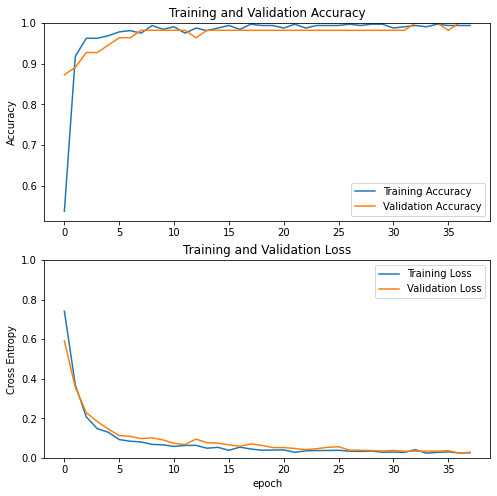

In [ ]:
metrics_visualization(history)

## Evaluation and Prediction


In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

  print("_______________________________________________________________________")
  print(classification_report(labels, predictions))

  return plt.show

In [ ]:
y_true = test_generator.classes
predict = model.predict_generator(test_generator)
y_pred = np.argmax(predict, axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Legitimate Transactions Detected (True Negatives):  25
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  6
Total Fraudulent Transactions:  6
_______________________________________________________________________
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00         6

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



<function matplotlib.pyplot.show>

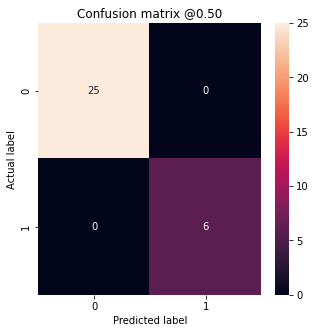

In [ ]:
# plotting confusion matrix and classfication report
plot_cm(y_true,y_pred)